In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [2]:
import dgl
from dgl.data.tree import SST
from dgl.data import SSTBatch

# Each sample in the dataset is a constituency tree. The leaf nodes
# represent words. The word is an int value stored in the "x" field.
# The non-leaf nodes have a special word PAD_WORD. The sentiment
# label is stored in the "y" feature field.
trainset = SST(mode='tiny')  # the "tiny" set has only five trees
tiny_sst = trainset.trees
num_vocabs = trainset.num_vocabs
num_classes = trainset.num_classes

vocab = trainset.vocab # vocabulary dict: key -> id
inv_vocab = {v: k for k, v in vocab.items()} # inverted vocabulary dict: id -> word

a_tree = tiny_sst[0]
for token in a_tree.ndata['x'].tolist():
    if token != trainset.PAD_WORD:
        print(inv_vocab[token], end=" ")

Extracting file to /Users/kexinhuang/.dgl/sst
Preprocessing...
Dataset creation finished. #Trees: 5
the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

In [11]:
graph = dgl.batch(tiny_sst)
x = graph.to_networkx()

In [13]:
x.degree

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [9]:
tiny_sst[0]

DGLGraph(num_nodes=71, num_edges=70,
         ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(), dtype=torch.int64), 'mask': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={})

In [22]:
G = nx.barabasi_albert_graph(100, 5, seed = 1)
C = nx.clustering(G)

In [23]:
nx.write_edgelist(G, 'fakegraph.adjlist')

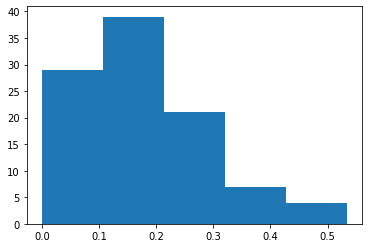

In [26]:
BINs = plt.hist(list(C.values()), bins = 5)

In [27]:
BINs

(array([29., 39., 21.,  7.,  4.]),
 array([0.        , 0.10666667, 0.21333333, 0.32      , 0.42666667,
        0.53333333]),
 <a list of 5 Patch objects>)

In [5]:
def aug_normalized_adjacency(adj):
    adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt).tocoo()

def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [22]:
A = nx.adjacency_matrix(G)
A = aug_normalized_adjacency(A)

In [11]:
features = np.eye(A.shape[0])
features = row_normalize(features)

In [14]:
from scipy.sparse import csr_matrix, isspmatrix
isspmatrix(A)

True

In [15]:
labels = np.zeros(A.shape[0], )

In [16]:
tmp = np.array(list(C.values()))
label_count = 5
for i in range(label_count):
    thr_down = np.percentile(tmp, i*(100/label_count))
    thr_up = np.percentile(tmp,(i+1)*(100/label_count))
    labels[np.where((tmp <= thr_up) & (tmp > thr_down))] = i

In [17]:
data_graph = [A, features, labels]

In [18]:
np.savez('fake_graph.npz', A, features, labels)

In [21]:
isspmatrix(np.load('fake_graph.npz', allow_pickle = True)['arr_0'])

False

In [97]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [34]:
import numpy as np
import scipy.sparse as sp
import torch
import sys
import pickle as pkl
import networkx as nx
#from normalization import fetch_normalization, row_normalize
from sklearn.metrics import f1_score

In [ ]:
def load_citation(dataset_str="cora", normalization="AugNormAdj", cuda=True):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str.lower(), names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]


    adj, features = preprocess_citation(adj, features, normalization)

    features = torch.FloatTensor(np.array(features.todense())).float()
    labels = torch.LongTensor(labels)
    labels = torch.max(labels, dim=1)[1]
    adj = sparse_mx_to_torch_sparse_tensor(adj).float()

    if cuda:
        features = features.cuda()
        adj = adj.cuda()
        labels = labels.cuda()

    return adj, features, labels

In [37]:
names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
dataset_str="cora"
objects = []
for i in range(len(names)):
    with open("../meta_gnn/data/ind.{}.{}".format(dataset_str.lower(), names[i]), 'rb') as f:
        if sys.version_info > (3, 0):
            objects.append(pkl.load(f, encoding='latin1'))
        else:
            objects.append(pkl.load(f))

x, y, tx, ty, allx, ally, graph = tuple(objects)
test_idx_reorder = parse_index_file("../meta_gnn/data/ind.{}.test.index".format(dataset_str))
test_idx_range = np.sort(test_idx_reorder)

features = sp.vstack((allx, tx)).tolil()
features[test_idx_reorder, :] = features[test_idx_range, :]
adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

In [36]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

In [45]:
adj.multiply(adj.T > adj)

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [42]:
adj.multiply(adj.T > adj)

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [44]:
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in Compressed Sparse Row format>

In [ ]:
def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def generate_graph(n):
    '''
    input: 
        - n: number of graphs
    output:
        - G_set: a list of nx graphs [G_1, G_2, ..., G_n]
        - F_set: features associated with each node in the graph [F_1, ..., F_n] where L_i is a dictionary {node_1: features_1, ....}
        - L_set: labels associated with each node in the graph [L_1, ..., L_n] where L_i is a dictionary {node_1: label_1, ....}
    '''    
    G_set = []
    F_set = []
    L_set = []
    
    for i in range(n):
        G = nx.barabasi_albert_graph(100, 5)
        labels = np.zeros(A.shape[0], )
        tmp = np.array(list(C.values()))
        label_count = 5
        for i in range(label_count):
            thr_down = np.percentile(tmp, i*(100/label_count))
            thr_up = np.percentile(tmp,(i+1)*(100/label_count))
            labels[np.where((tmp <= thr_up) & (tmp > thr_down))] = i
            
        features = np.eye(A.shape[0])
        features = row_normalize(features)
        G_set.append(G)
        F_set.append(features)
        L_set.append(labels)
    return G_set, F_set, L_set

In [ ]:
def graph_to_subgraphs(G, features, labels, h, idx):
    '''
    input:
        - G: a graph
        - features: node features
        - labels: node labels
        - h: h hops
        - idx: graph index
    output:
        - S_list: a list of DGL subgraphs where each subgraph is centered on a node i. {node i: adj_i, ....}
    '''
    S_list = {}
    
    for i in list(G.nodes):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features = features[h_hops_neighbor]
        labels = labels[h_hops_neighbor]
        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['x'] = features
        S.ndata['y'] = labels
        S.ndata['center_node'] = i
        S.ndata['graph_idx'] = idx
        S_list.append(S)        
    return S_list    
        

In [ ]:
def generate_dataset(n, h):
    '''
    generate h hops subgraphs for n 
    
    input:
        - n: use in total n graphs
        - h: h hops subgraph
    '''
    
    total_subgraph_list = []
    G_set, F_set, L_set = generate_graph(n)
    for i in range(len(G_set)):
        G = G_set[i]
        F = F_set[i]
        L = L_set[i]
        
        S_list = graph_to_subgraphs(G, F, L, h, i)
        total_subgraph_list = total_subgraph_list + S_list
        
    return total_subgraph_list